In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
mail_data = pd.read_csv("mail_data.csv")
mail_data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
#Thông tin tổng quan
mail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
#kiểm tra giá trị thiếu
mail_data.isnull().sum() 

Category    0
Message     0
dtype: int64

In [4]:
df = mail_data.where((pd.notnull(mail_data)), '') 
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [5]:
#kiểm tra lại dữ liệu
df.shape

(5572, 2)

In [6]:
#chuyển đổi (mã hóa) giá trị trong cột Category từ chuỗi sang số: spam -> 0, ham -> 1
df['Category'] = df['Category'].map({'spam': 0, 'ham': 1})
df.head()

#or
#df.loc[df['Category'] == 'spam', 'Category',] = 0
#df.loc[df['Category'] == 'ham', 'Category',] = 1
#df.head()

,Category,Message
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Tách dữ liệu: X là nội dung tin nhắn (đầu vào), Y là nhãn phân loại (0 = spam, 1 = ham)
X = df['Message']
Y = df['Category']
print(X, Y)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object 0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: Category, Length: 5572, dtype: int64


In [8]:
# Chia dữ liệu: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Chuyển văn bản thành vector TF-IDF, bỏ từ vô nghĩa tiếng Anh
feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", binary=True)

# Học đặc trưng từ tập train
X_train_features = feature_extraction.fit_transform(X_train)

# Áp dụng đặc trưng đó cho tập testa
X_test_features = feature_extraction.transform(X_test)

# Xem thông tin tổng quan của dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   int64 
 1   Message   5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [28]:
#Tìm kiếm mô hình 
from lazypredict.Supervised import LazyClassifier
X_train_dense = X_train_features.toarray()
X_test_dense = X_test_features.toarray()
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_dense, X_test_dense, y_train, y_test)
print(models)

In [9]:
# mô hình hồi quy logistic để phân loại
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000, solver='liblinear')

# Chuyển nhãn y về kiểu số nguyên (int) để mô hình hiểu được
y_train = y_train.astype("int")
y_test = y_test.astype("int")

# Huấn luyện mô hình trên tập dữ liệu train
model.fit(X_train_features, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [10]:
# Dự đoán nhãn của tập train
prediction_train_data = model.predict(X_train_features)

# Tính độ chính xác (Accuracy) trên tập train
accuracy_train_data = accuracy_score(y_train, prediction_train_data)

# In ra kết quả độ chính xác
print("Accuracy on train data:", accuracy_train_data)


Accuracy on train data: 0.9652232443347544


In [11]:
import pickle  # lưu và tải lại mô hình
# Lưu mô hình Logistic Regression đã huấn luyện
pickle.dump(model, open("logistic_regression.pkl", "wb"))
# Lưu bộ biến đổi TF-IDF (feature_extraction) để dùng lại khi dự đoán
pickle.dump(feature_extraction, open("feature_extraction.pkl", "wb"))


In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
y_pred = model.predict(X_test_features)

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))
print("AUC:", round(auc, 3))


Accuracy: 0.966
Precision: 0.962
Recall: 1.0
F1 Score: 0.981
AUC: 0.872


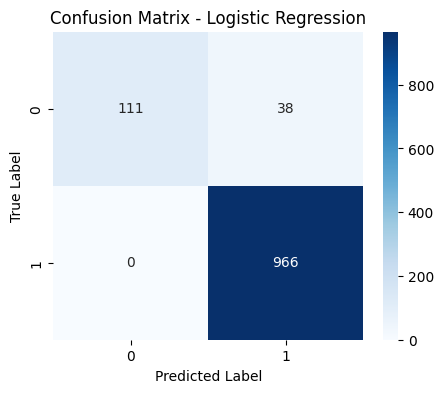

In [13]:
# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


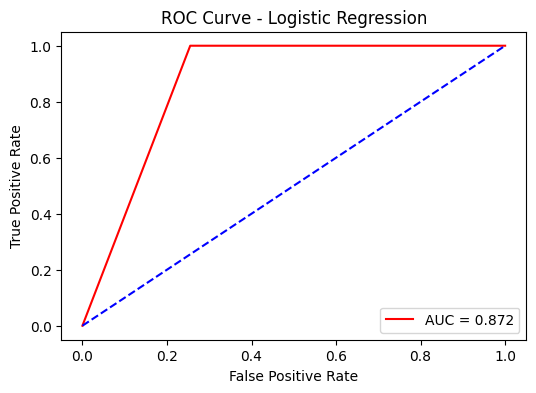

In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='red', label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [15]:
# mô hình naive bayes
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
)

# khởi tạo và huấn luyện mô hình naive bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_features, y_train)

# dự đoán và đánh giá
y_pred_nb = model_nb.predict(X_test_features)
y_prob = model_nb.predict_proba(X_test_features)[:, 1]

acc = accuracy_score(y_test, y_pred_nb)
prec = precision_score(y_test, y_pred_nb)
rec = recall_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.974
Precision: 0.971
Recall: 1.000
F1 Score: 0.985


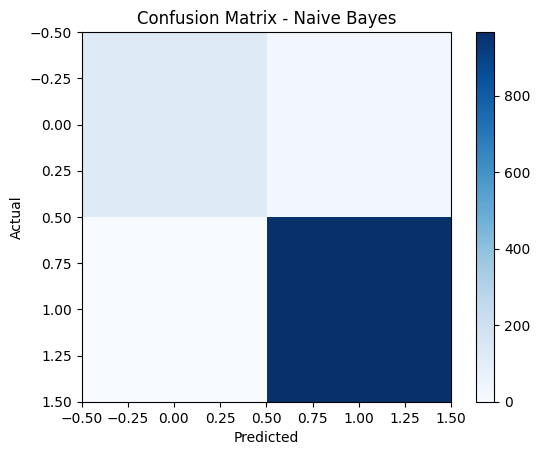

[[120  29]
 [  0 966]]


In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_nb)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()

print(cm)

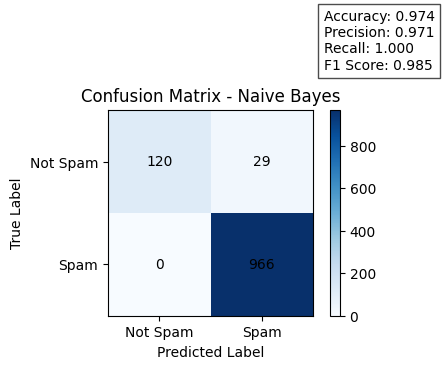

In [17]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes")
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ["Not Spam", "Spam"])
plt.yticks(tick_marks, ["Not Spam", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Ghi số lên ô
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, cm[i][j], ha="center", va="center", color="black")
# Ghi thông số lên góc ảnh
plt.text(1.6, -0.9,
         f"Accuracy: {acc:.3f}\nPrecision: {prec:.3f}\nRecall: {rec:.3f}\nF1 Score: {f1:.3f}",
         fontsize=10, bbox=dict(facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

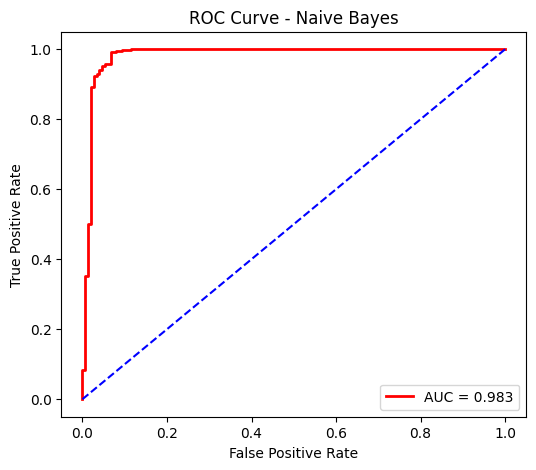

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='red', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.title("ROC Curve - Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [19]:
import pickle
with open("model_naive_bayes.pkl", "wb") as f:
    pickle.dump(model_nb, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(feature_extraction, f)

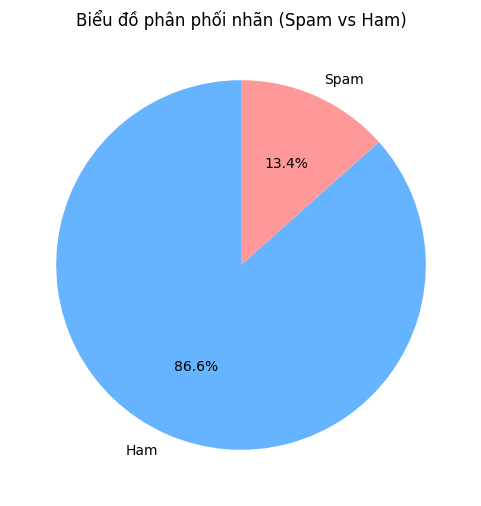

In [21]:
# Vẽ biểu đồ tròn thể hiện tỉ lệ spam vs ham
import matplotlib.pyplot as plt
import seaborn as sns

# Đếm số lượng spam và ham
label_counts = df['Category'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['Ham', 'Spam'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Biểu đồ phân phối nhãn (Spam vs Ham)')
plt.show()


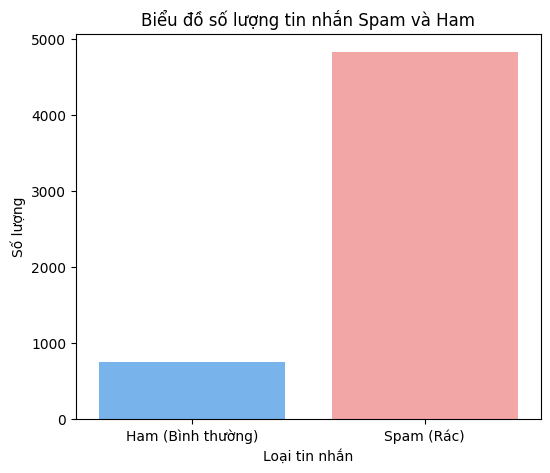

In [22]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Category', data=df, palette=['#66b3ff','#ff9999'])
plt.title('Biểu đồ số lượng tin nhắn Spam và Ham')
plt.xlabel('Loại tin nhắn')
plt.ylabel('Số lượng')
plt.xticks(ticks=[0, 1], labels=['Ham (Bình thường)', 'Spam (Rác)'])
plt.show()


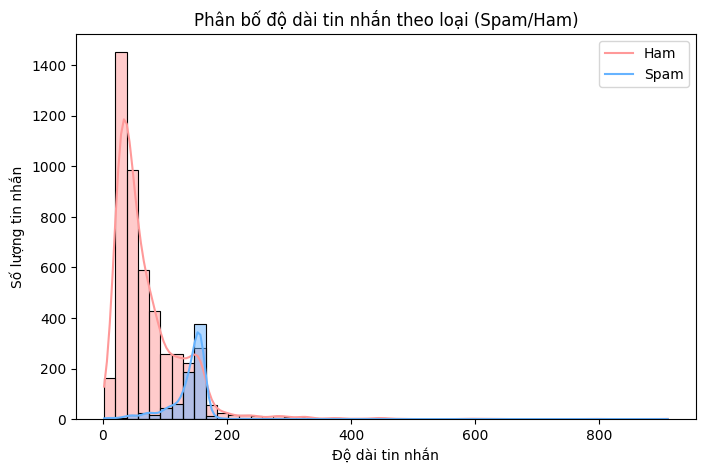

In [23]:
df['Message_Length'] = df['Message'].apply(len)

# Vẽ biểu đồ phân bố
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Message_Length', hue='Category', bins=50, kde=True, palette=['#66b3ff','#ff9999'])
plt.title('Phân bố độ dài tin nhắn theo loại (Spam/Ham)')
plt.xlabel('Độ dài tin nhắn')
plt.ylabel('Số lượng tin nhắn')
plt.legend(['Ham', 'Spam'])
plt.show()


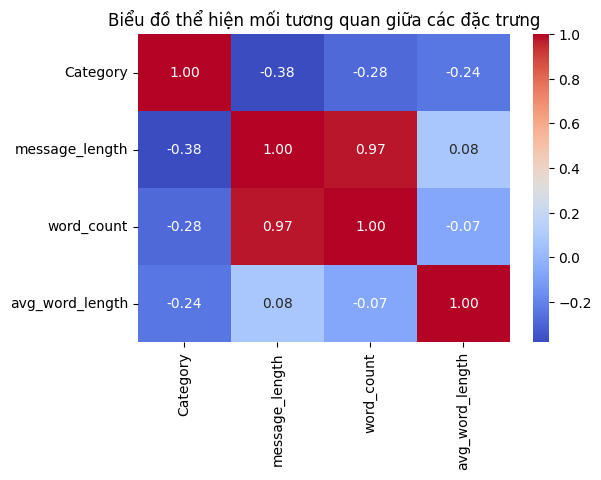

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = mail_data.copy()
df = df.where(pd.notnull(df), '')

# Mã hóa nhãn
df['Category'] = df['Category'].map({'spam': 0, 'ham': 1})

# Tạo thêm các đặc trưng số để tính tương quan
df['message_length'] = df['Message'].apply(len)                
df['word_count'] = df['Message'].apply(lambda x: len(x.split()))  
df['avg_word_length'] = df['Message'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

# Chọn các cột đặc trưng để phân tích tương quan
corr_features = df[['Category', 'message_length', 'word_count', 'avg_word_length']]

# Vẽ biểu đồ heatmap thể hiện mối tương quan
plt.figure(figsize=(6, 4))
sns.heatmap(corr_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Biểu đồ thể hiện mối tương quan giữa các đặc trưng")
plt.show()


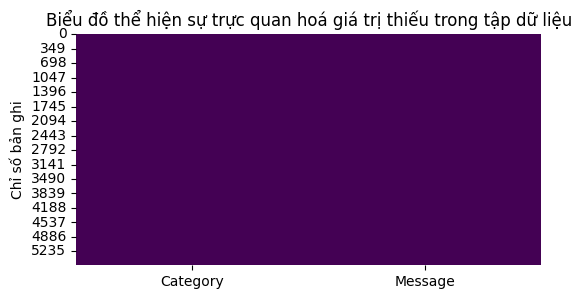

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
sns.heatmap(mail_data.isnull(), cbar=False, cmap='viridis')
plt.title("Biểu đồ thể hiện sự trực quan hoá giá trị thiếu trong tập dữ liệu")
plt.ylabel("Chỉ số bản ghi")
plt.show()


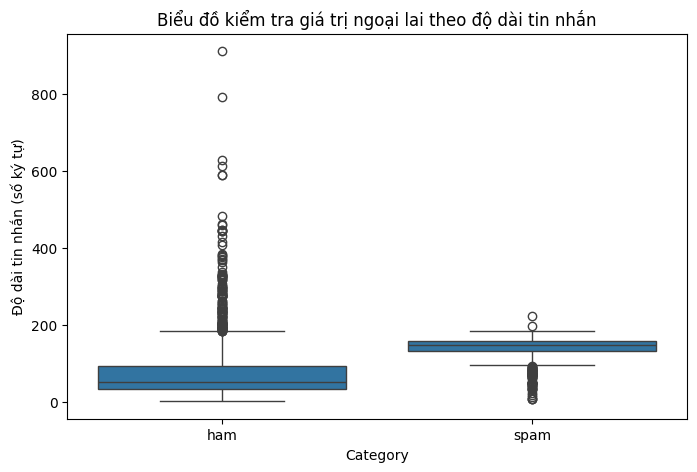

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

mail_data['Message_Length'] = mail_data['Message'].apply(len)

plt.figure(figsize=(8,5))
sns.boxplot(x='Category', y='Message_Length', data=mail_data)
plt.title("Biểu đồ kiểm tra giá trị ngoại lai theo độ dài tin nhắn")
plt.ylabel("Độ dài tin nhắn (số ký tự)")
plt.show()


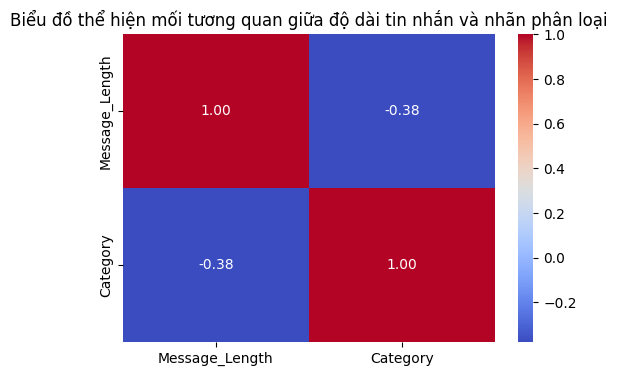

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Mã hóa nhãn Category: spam -> 0, ham -> 1
mail_data['Category'] = mail_data['Category'].map({'spam': 0, 'ham': 1})

# Thêm cột độ dài tin nhắn
mail_data['Message_Length'] = mail_data['Message'].apply(len)

# Chọn hai cột để tính tương quan
num_plot = ['Message_Length', 'Category']

# Vẽ biểu đồ Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(mail_data[num_plot].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Biểu đồ thể hiện mối tương quan giữa độ dài tin nhắn và nhãn phân loại", fontsize=12)
plt.show()
